# Simulation Func for Regression 

In [1]:
import pandas as pd
import numpy as np
import lifelines as ll
# import sksurv as sks
import matplotlib.pyplot as plt
from bart_survival import surv_bart as sb
from bart_survival import simulation as sm
import lifelines as ll
from lifelines import KaplanMeierFitter
import subprocess
import importlib

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import sys
sys.path.append("../py/")
sys.path.append("../src/")
import _conditions1 as cn
import _functions1 as fn
import _sim_iter1 as si
import _plot_fx as pltf
#s
import sim_adj as sim

In [157]:
importlib.reload(sim)

<module 'sim_adj' from '/Users/jacobtiegs/projects/bart_paper/bart_survival_paper/notebook/../src/sim_adj.py'>

In [26]:
import lifelines as ll
kpm = ll.KaplanMeierFitter()


mean shape 3.0
mean scale 7.0
13.0
mean time draws 6.156399357353597


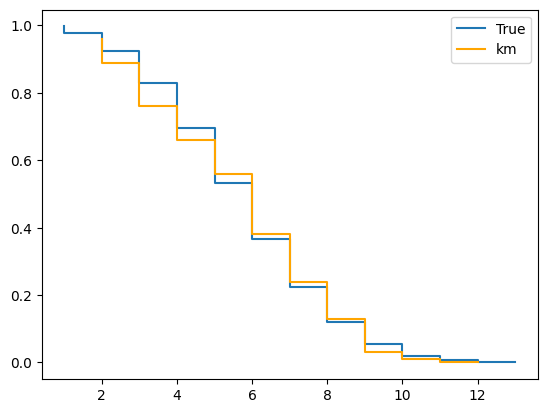

In [3]:
reg_1 = {
    "type": "Simple, 1 group, 20% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[1],
    "scale_f": "7*x_mat[:,0]",
    "shape_f": "3",
    "cens_scale":3.3
}

rng = np.random.default_rng(110)
x_mat = sim.get_x_matrix(
    N = 100, 
    x_vars = reg_1["x_vars"], 
    VAR_CLASS=reg_1["VAR_CLASS"],
    VAR_PROB=reg_1["VAR_PROB"],
    rng=rng
    )
event, sv_true, sv_scale_true = sim.simulate_survival(
    x_mat = x_mat,
    scale_f=reg_1["scale_f"],
    shape_f=reg_1["shape_f"],
    # eos=20,
    rng=rng,
    # force_eos=True
)

kpm = ll.KaplanMeierFitter()
kpm.fit(event["t_event"], event["status"])
km = kpm.survival_function_.values.T.reshape(-1,1)[1:]
kmt = kpm.timeline.reshape(-1,1)[1:]
km

sv = sv_true["sv_true"]
ttt = sv_true["true_times"]
for i in range(1):
    plt.step(ttt, sv[i,:], label="True")
    plt.step(kmt, km, label = "km", color="orange")
plt.legend()



In [159]:

BSM = sb.BartSurvModel()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [163]:
importlib.reload(sim)

<module 'sim_adj' from '/Users/jacobtiegs/projects/bart_paper/bart_survival_paper/notebook/../src/sim_adj.py'>

mean shape 1.7229357798165128
mean scale 11.738532110091743
49.0
mean time draws 9.997151366861916


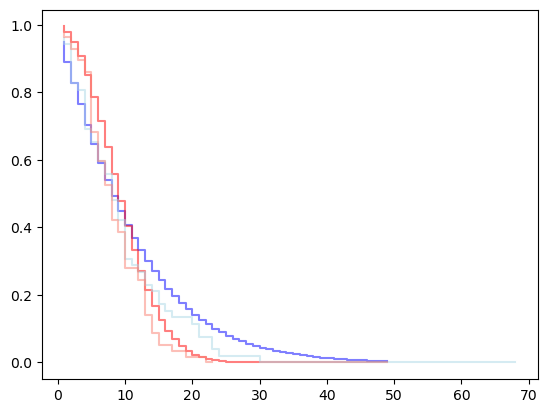

In [19]:

# reg_1 = {
#     "type": "Simple, 1 group, 20% cens",
#     "x_vars": 1, 
#     "VAR_CLASS": [2],
#     "VAR_PROB":[1],
#     "scale_f": "7*x_mat[:,0]",
#     "shape_f": "3",
#     "cens_scale":3.3
# }
reg_1 = {
    "type": "Simple, 2 group, 20% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[.5],
    "scale_f": "12 - .5 *x_mat[:,0]",
    "shape_f": "1.2 + 1 *x_mat[:,0]",
    "cens_scale":3
}

ends = []
for i in range(1):
	rng = np.random.default_rng(99)
	x_mat = sim.get_x_matrix(
		N = 109, 
		x_vars = reg_1["x_vars"], 
		VAR_CLASS=reg_1["VAR_CLASS"],
		VAR_PROB=reg_1["VAR_PROB"],
		rng=rng
		)
	event, sv_true, sv_scale_true = sim.simulate_survival(
		x_mat = x_mat,
		scale_f=reg_1["scale_f"],
		shape_f=reg_1["shape_f"],
		rng=rng
	)
	ends.append(sv_true["true_times"].max())
msk = x_mat[:,0] == 0


kpm = ll.KaplanMeierFitter()
kpm.fit(event["t_event"][msk], event["status"][msk])
km0 = kpm.survival_function_.values.T.reshape(-1,1)[1:]
kmt0 = kpm.timeline.reshape(-1,1)[1:]

kpm = ll.KaplanMeierFitter()
kpm.fit(event["t_event"][~msk], event["status"][~msk])
km1 = kpm.survival_function_.values.T.reshape(-1,1)[1:]
kmt1 = kpm.timeline.reshape(-1,1)[1:]


sv0 = sv_true["sv_true"][msk,:].mean(0)
sv1 = sv_true["sv_true"][~msk,:].mean(0)
ttt = sv_true["true_times"]
# for i in range(1):
plt.step(ttt, sv0, label="True", color = "blue", alpha=0.5)
plt.step(ttt, sv1, label="True", color = "red", alpha=0.5)
plt.step(kmt0, km0, label = "km", color="lightblue", alpha=0.5)
plt.step(kmt1, km1, label = "km", color="salmon", alpha=0.5)
# plt.legend()




In [527]:
# np.quantile(sv_true["sv_true"], [0.1,0.25,0.5,0.75,0.9],)
# sv_true["sv_true"][0,:]


# sv_true["sv_true"][0,:]

def get_quant_times(sv_true_c, true_times, quant=[0.9,0.75,0.5,0.25,0.1]):
	qnt_t = []
	for i in quant:
		tmp = np.abs(sv_true_c - i)
		idx = tmp == tmp.min()
		qnt_t.append(true_times[idx])
	return np.array(qnt_t)

In [529]:
c1 = sv_true["sv_true"].mean(0)
c1_q = get_quant_times(c1, sv_true["true_times"])

In [530]:
c1_q
# c1[c1_q-1]

# c1_q[c1-1]
# sv_true["sv_true"][[0,-3],:]

array([[ 2],
       [ 4],
       [ 9],
       [14],
       [20]])

In [442]:
def get_quant_events(qnt_t, event):

	q = np.array(qnt_t)
	# q = np.quantile(sv_true["true_times"], quant, method=method)
	# print(q)
	et_ = event["t_event"].copy()
	et_out = event["t_event"].copy()
	es_out = event["status"].copy()
	for i in range(q.shape[0]):
		if i == 0:
			msk = et_<=q[i]
			et_out[msk] = q[i]
			# print(np.unique(et_out))
		else:
			msk = (q[i-1] < et_) & (et_ <= q[i])
			et_out[msk] = q[i]
			# print(np.unique(et_out))
			if i == q.shape[0]-1:
				msk = et_ > q[i]
				et_out[msk] = q[i]
				es_out[msk] = 0

	return {"t_event":et_out, "status":es_out}


# Complex Regression

In [50]:
reg_1 = {
    # "type": "Simple, 1 group, 20% cens",
    "x_vars": 10, 
    "VAR_CLASS": [1,1,1,1,1,1,1,1,1,1],
    "VAR_PROB":[None,None,None,None,None,None,None,None,None,None],
    "scale_f" : "np.exp(3 + 0.5*np.sin(np.pi * x_mat[:,0] * x_mat[:,1]) + np.power((x_mat[:,2]-0.5), 2) + 0.5* x_mat[:,3] + 0.25 * x_mat[:,4])",
    # "scale_f": "20 + 5*(x_mat[:,0] + x_mat[:,1] + x_mat[:,2] + x_mat[:,3] + x_mat[:,4] + x_mat[:,5] + 10*x_mat[:,6])",
    "shape_f": "2",
    "cens_scale":None
}


In [51]:
rng = np.random.default_rng(99)
x_mat = sm.get_x_matrix(
    N = 400, 
    x_vars = reg_1["x_vars"], 
    VAR_CLASS=reg_1["VAR_CLASS"],
    VAR_PROB=reg_1["VAR_PROB"],
    rng=rng
    )
event, sv_true, sv_scale_true = sm.simulate_survival(
    x_mat = x_mat,
    scale_f=reg_1["scale_f"],
    shape_f=reg_1["shape_f"],
    rng=rng
)

mean shape 2.0
mean scale 44.01964734948047
mean time draws 39.93344379031392


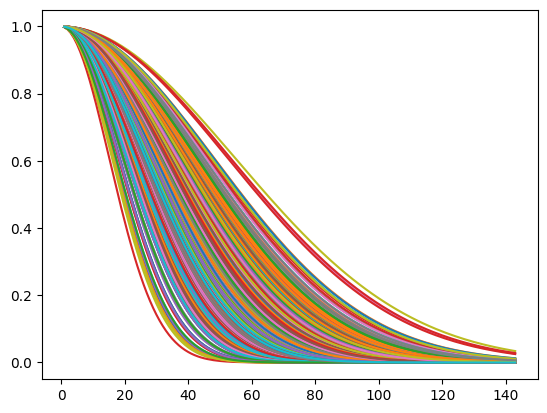

In [52]:
sv = sv_true["sv_true"]
ttt = sv_true["true_times"]
for i in range(400):
    plt.plot(ttt, sv[i,:])